<a href="https://colab.research.google.com/github/Almamun001/Thesis-Model-MHA-/blob/main/MentalBERT_BiLSTM_CNN_(Documented).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries for the mental health classification project
# Uncomment the lines below if running in Google Colab for the first time

# Core ML libraries
# !pip install -q tensorflow==2.15.0 tensorflow-text==2.15.0

# Transformers library for MentalBERT
# !pip install -q transformers

print("Installation completed! All required libraries are ready.")

Installation completed! All required libraries are ready.


## Table of Contents

1. [Setup and Installation](#1-setup-and-installation)
2. [Data Loading and Initial Exploration](#2-data-loading-and-initial-exploration)
3. [Data Preprocessing](#3-data-preprocessing)
4. [Exploratory Data Analysis](#4-exploratory-data-analysis)
5. [Feature Engineering](#5-feature-engineering)
6. [Data Balancing](#6-data-balancing)
7. [Model Architecture](#7-model-architecture)
8. [Training](#8-training)
9. [Evaluation](#9-evaluation)
10. [Model Saving](#10-model-saving)

---

# 1. Setup and Installation

This section handles the installation of required dependencies and initial setup for the mental health classification project.

In [ ]:
# Import all required libraries for the mental health classification project

# Data manipulation and analysis
import numpy as np
import pandas as pd
import os
import re
import warnings

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Machine learning utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import RobustScaler

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Bidirectional, LSTM, Conv1D,
    GlobalMaxPooling1D, Concatenate, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# NLP and transformer libraries
from transformers import AutoTokenizer, TFAutoModel
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
# Configure TensorFlow to use legacy Keras (required for compatibility)
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

print("✅ TensorFlow configured to use legacy Keras")

✅ TensorFlow configured to use legacy Keras


In [ ]:
# Configure plotting style and suppress warnings
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✅ Plotting style configured and warnings suppressed")

✅ Plotting style configured and warnings suppressed


In [ ]:
# Mount Google Drive to access the dataset (only needed in Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted successfully!")
except ImportError:
    print("ℹ️  Not running in Google Colab - skipping drive mount")

Mounted at /content/drive
✅ Google Drive mounted successfully!


# 2. Data Loading and Initial Exploration

This section handles mounting Google Drive (if using Colab) and loading the mental health dataset for analysis.

In [ ]:
# Load the mental health dataset
file_path = "/content/drive/MyDrive/Thesis Work/Main Datasets/Mental Health Dataset (Main).csv"

try:
    df = pd.read_csv(file_path)
    print("✅ Dataset loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
    print(f"📝 Columns: {list(df.columns)}")

    # Display the first few rows
    print("\n🔍 First 5 rows of the dataset:")
    display(df.head())

except FileNotFoundError:
    print(f"❌ Error: The file was not found at {file_path}")
    print("📁 Please make sure the path is correct and the file exists.")
    print("💡 If running locally, update the file_path variable to your dataset location.")
except Exception as e:
    print(f"❌ Error loading dataset: {str(e)}")

✅ Dataset loaded successfully!
📊 Dataset shape: (52910, 3)
📝 Columns: ['Unnamed: 0', 'statement', 'status']

🔍 First 5 rows of the dataset:


,Unnamed: 0,statement,status
0,0.0,oh my gosh,Anxiety
1,1.0,trouble sleeping confused mind restless heart....,Anxiety
2,2.0,All wrong back off dear forward doubt. Stay in...,Anxiety
3,3.0,Ive shifted my focus to something else but Im ...,Anxiety
4,4.0,Im restless and restless its been a month now ...,Anxiety


In [ ]:
# Initial data cleaning and inspection

# Remove unnecessary index column if it exists
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)
    print("✅ Dropped 'Unnamed: 0' column")

# Display comprehensive dataset information
print("\n📋 Dataset Information:")
print("=" * 50)
df.info()

print("\n🔍 Missing Values Analysis:")
print("=" * 30)
missing_summary = df.isnull().sum()
if missing_summary.sum() == 0:
    print("✅ No missing values found!")
else:
    print(missing_summary[missing_summary > 0])

print("\n📊 Dataset Statistics:")
print("=" * 25)
print(f"Total samples: {len(df):,}")
print(f"Number of features: {df.shape[1]}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


✅ Dropped 'Unnamed: 0' column

📋 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52910 entries, 0 to 52909
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52535 non-null  object
 1   status     52908 non-null  object
dtypes: object(2)
memory usage: 826.8+ KB

🔍 Missing Values Analysis:
statement    375
status         2
dtype: int64

📊 Dataset Statistics:
Total samples: 52,910
Number of features: 2
Memory usage: 34.07 MB


# 3. Data Preprocessing

This section handles data cleaning, missing value treatment, and text preprocessing to prepare the dataset for analysis and modeling.

In [ ]:
# Handle missing values in the 'statement' column
initial_shape = df.shape[0]

# Remove rows with missing statements (critical for text analysis)
df.dropna(subset=['statement'], inplace=True)

final_shape = df.shape[0]
removed_rows = initial_shape - final_shape

print(f"🧹 Missing value cleanup completed:")
print(f"   Initial rows: {initial_shape:,}")
print(f"   Final rows: {final_shape:,}")
print(f"   Removed rows: {removed_rows:,} ({removed_rows/initial_shape*100:.2f}%)")

if removed_rows == 0:
    print("✅ No missing values in 'statement' column!")

🧹 Missing value cleanup completed:
   Initial rows: 52,910
   Final rows: 52,535
   Removed rows: 375 (0.71%)


In [ ]:
# Text preprocessing: Remove HTML tags and hyperlinks
import re

def remove_html_and_hyperlinks(text):
    """
    Clean text by removing HTML tags and hyperlinks.

    Args:
        text (str): Input text to clean

    Returns:
        str: Cleaned text
    """
    if isinstance(text, str):
        # Remove HTML tags using regex
        clean = re.compile('<.*?>')
        text = re.sub(clean, '', text)

        # Remove hyperlinks (both http and https)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'https\S+', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())
    return text

# Apply text cleaning to the statement column
if 'df' in locals() and 'statement' in df.columns:
    print("🧹 Cleaning text data...")

    # Show example before cleaning
    print("📝 Example before cleaning:")
    print(f"   {df['statement'].iloc[0][:100]}...")

    # Apply cleaning
    df['statement'] = df['statement'].apply(remove_html_and_hyperlinks)

    # Show example after cleaning
    print("\n✨ Example after cleaning:")
    print(f"   {df['statement'].iloc[0][:100]}...")

    print("\n✅ Text cleaning completed!")
else:
    print("❌ DataFrame not loaded or 'statement' column missing.")


🧹 Cleaning text data...
📝 Example before cleaning:
   oh my gosh...

✨ Example after cleaning:
   oh my gosh...

✅ Text cleaning completed!


In [ ]:
# Display the cleaned dataset
print("📊 Cleaned Dataset Preview:")
print("=" * 30)
display(df)

📊 Cleaned Dataset Preview:


,statement,status
0,oh my gosh,Anxiety
1,trouble sleeping confused mind restless heart....,Anxiety
2,All wrong back off dear forward doubt. Stay in...,Anxiety
3,Ive shifted my focus to something else but Im ...,Anxiety
4,Im restless and restless its been a month now ...,Anxiety
...,...,...
52905,Nobody takes me seriously Ive 24M dealt with d...,Anxiety
52906,selfishness I dont feel very good its like I d...,Anxiety
52907,Is there any way to sleep better? I cant sleep...,Anxiety
52908,Public speaking tips? Hi all. I have to give a...,Anxiety


📊 Mental Health Status Distribution Analysis


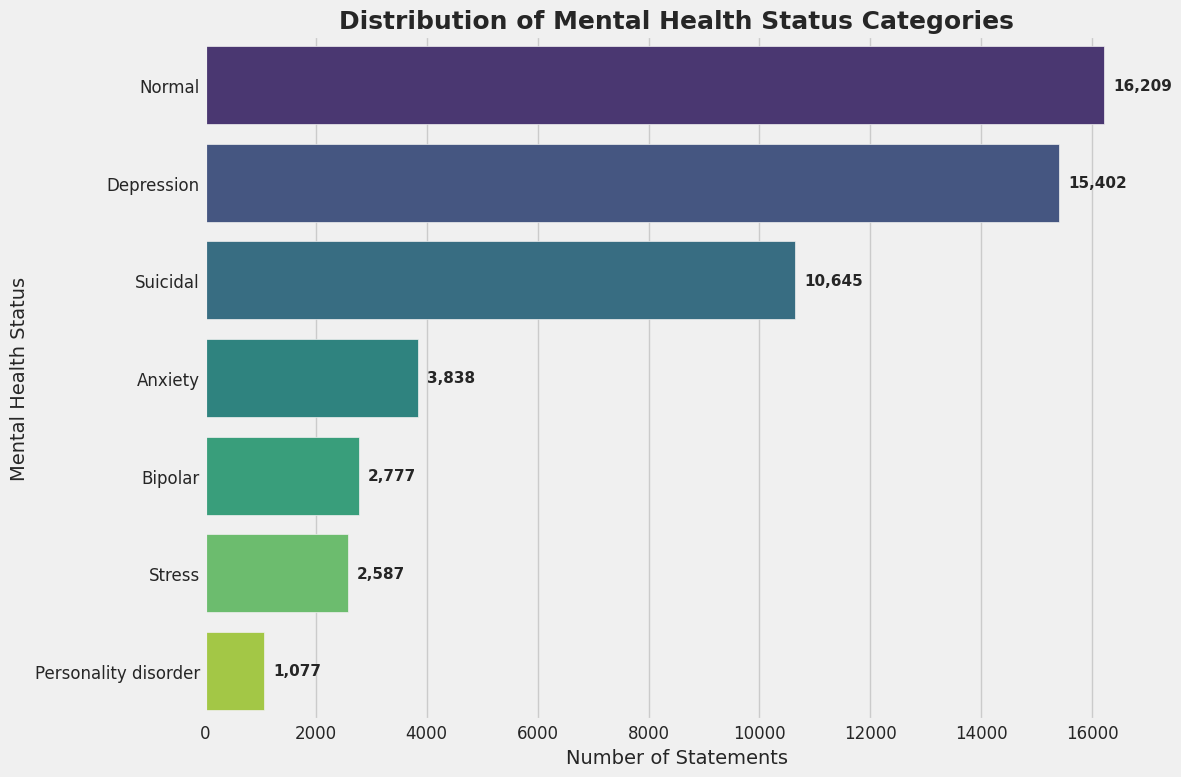


📈 Detailed Class Distribution:
-----------------------------------
Normal         : 16,209 samples ( 30.9%)
Depression     : 15,402 samples ( 29.3%)
Suicidal       : 10,645 samples ( 20.3%)
Anxiety        :  3,838 samples (  7.3%)
Bipolar        :  2,777 samples (  5.3%)
Stress         :  2,587 samples (  4.9%)
Personality disorder:  1,077 samples (  2.1%)

🎯 Total samples: 52,535
📊 Number of classes: 7
⚖️  Class balance ratio: 15.1:1 (max:min)


In [ ]:
# Analyze the distribution of mental health status categories

print("📊 Mental Health Status Distribution Analysis")
print("=" * 45)

# Create a comprehensive visualization
plt.figure(figsize=(12, 8))
status_counts = df['status'].value_counts()

# Plot the distribution
sns.countplot(y=df['status'], order=status_counts.index, palette='viridis')
plt.title('Distribution of Mental Health Status Categories', fontsize=18, fontweight='bold')
plt.xlabel('Number of Statements', fontsize=14)
plt.ylabel('Mental Health Status', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add count labels on bars
ax = plt.gca()
for i, (status, count) in enumerate(status_counts.items()):
    ax.text(count + max(status_counts) * 0.01, i, f'{count:,}',
            va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Display detailed statistics
print("\n📈 Detailed Class Distribution:")
print("-" * 35)
for status, count in status_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{status:<15}: {count:>6,} samples ({percentage:>5.1f}%)")

print(f"\n🎯 Total samples: {len(df):,}")
print(f"📊 Number of classes: {df['status'].nunique()}")
print(f"⚖️  Class balance ratio: {status_counts.max() / status_counts.min():.1f}:1 (max:min)")

# 4. Exploratory Data Analysis (EDA)

This section provides comprehensive analysis of the dataset including class distribution, text patterns, and visualization of key insights.

🔤 Generating Word Clouds for Mental Health Categories

1. Analyzing 'Depression' category...


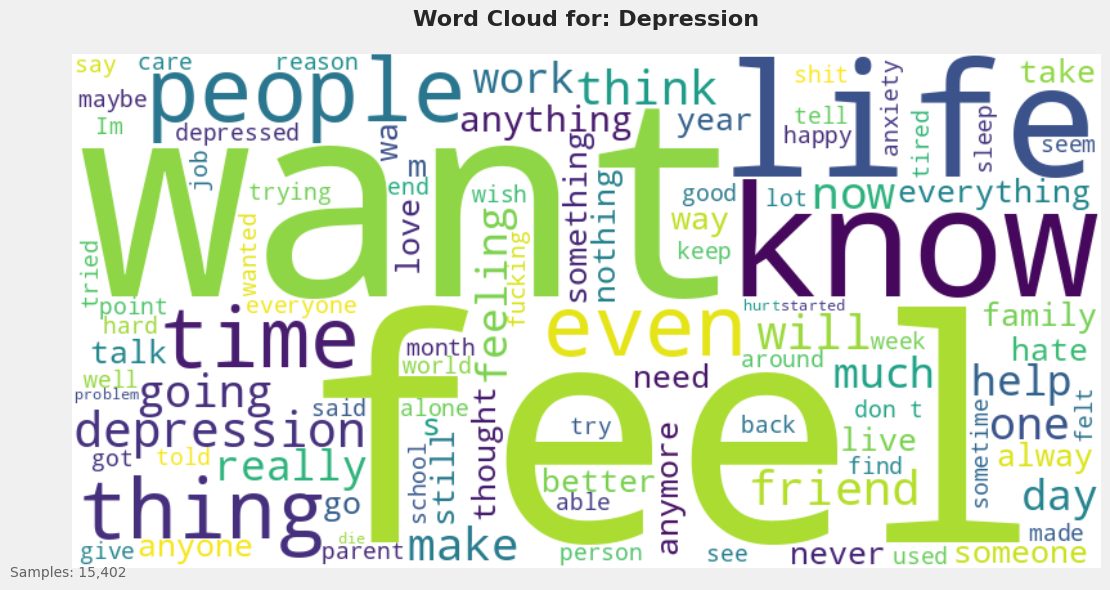


2. Analyzing 'Anxiety' category...


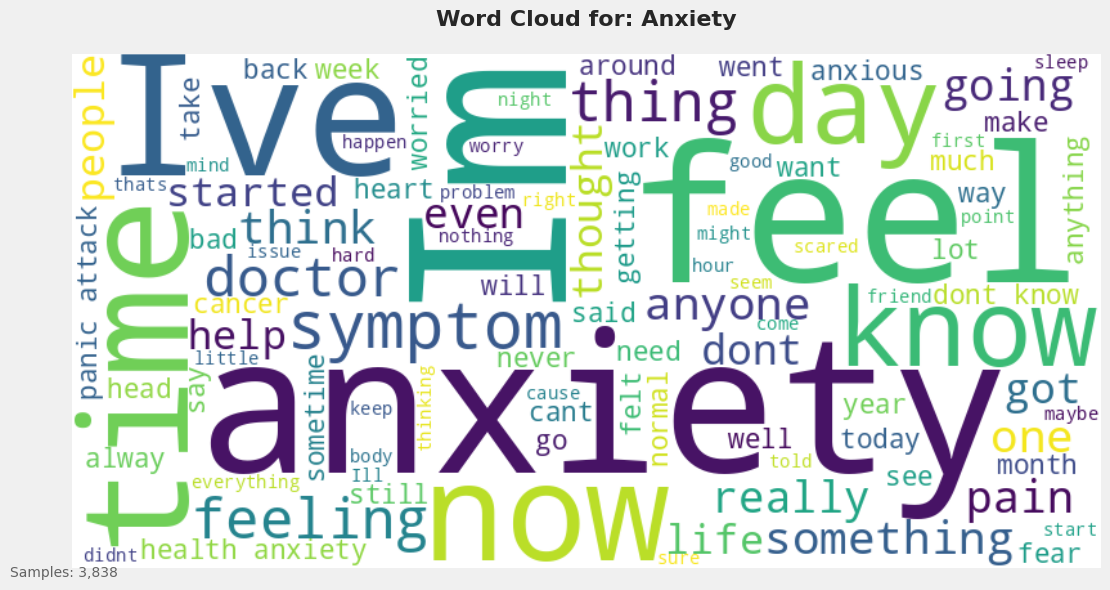


3. Analyzing 'Suicidal' category...


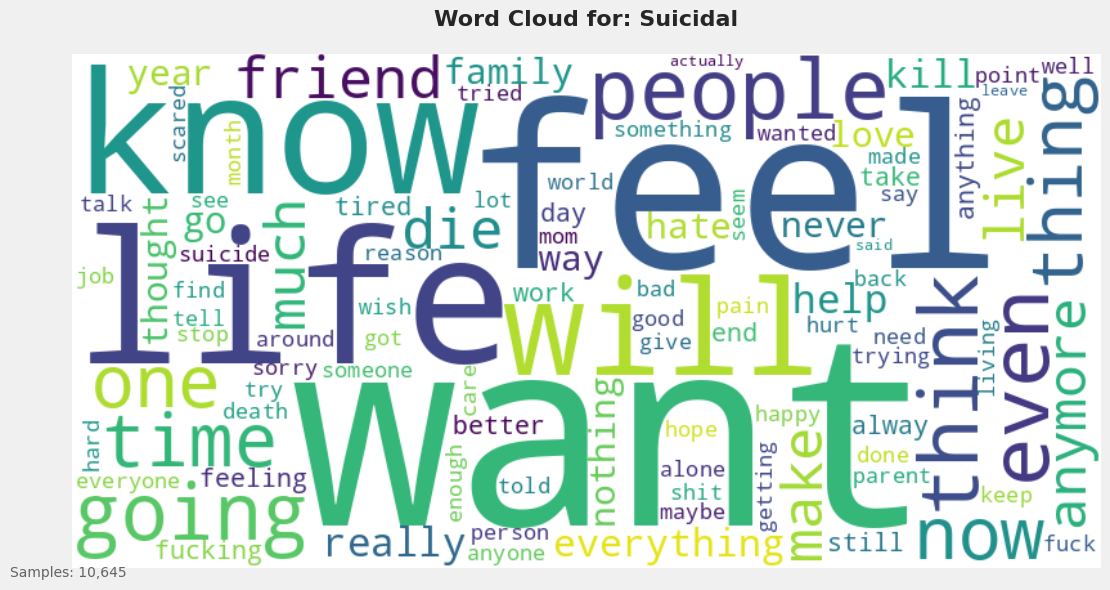


4. Analyzing 'Normal' category...


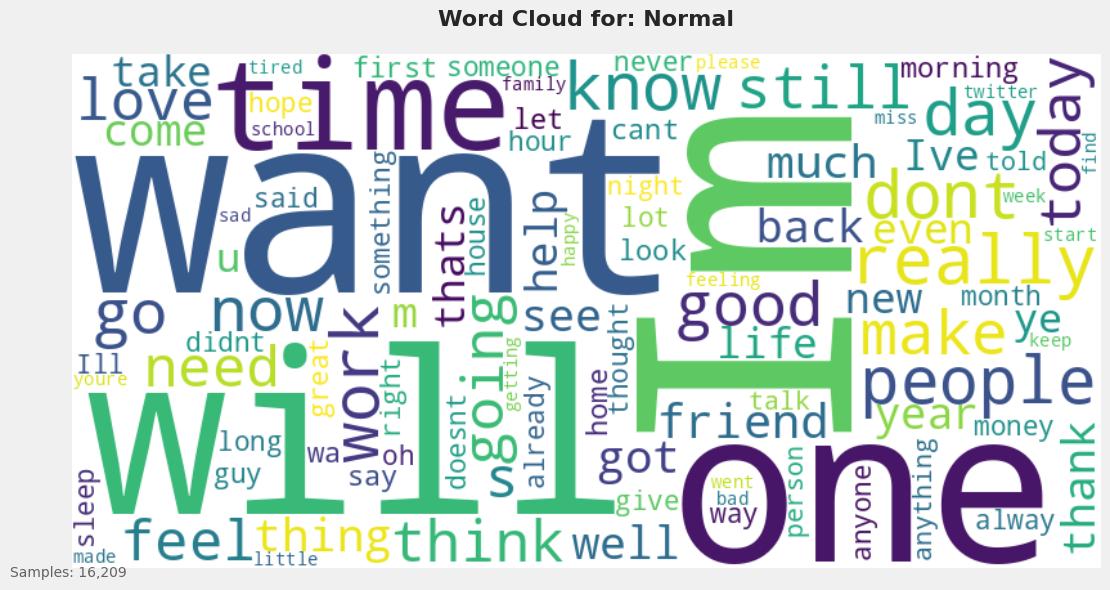

In [ ]:
# Generate word clouds for different mental health categories

def generate_wordcloud(category, figsize=(12, 6)):
    """
    Generate and display a word cloud for a specific mental health category.

    Args:
        category (str): Mental health category to analyze
        figsize (tuple): Figure size for the plot
    """
    # Filter text for the specific category
    category_text = ' '.join(df[df['status'] == category]['statement'])

    if not category_text.strip():
        print(f"⚠️  No text data available for category: {category}")
        return

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100,
        relative_scaling=0.5,
        stopwords=None  # Can add custom stopwords if needed
    ).generate(category_text)

    # Display the word cloud
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for: {category}', fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')

    # Add sample count
    sample_count = len(df[df['status'] == category])
    plt.figtext(0.02, 0.02, f'Samples: {sample_count:,}', fontsize=10, alpha=0.7)

    plt.tight_layout()
    plt.show()

# Generate word clouds for key categories
print("🔤 Generating Word Clouds for Mental Health Categories")
print("=" * 55)

categories_to_analyze = ['Depression', 'Anxiety', 'Suicidal', 'Normal']

for i, category in enumerate(categories_to_analyze, 1):
    if category in df['status'].values:
        print(f"\n{i}. Analyzing '{category}' category...")
        generate_wordcloud(category)
    else:
        print(f"⚠️  Category '{category}' not found in dataset")



In [ ]:
# Download and setup NLTK resources for text processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

print("📥 Downloading NLTK resources...")

try:
    # Download necessary NLTK data
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('punkt_tab', quiet=True)

    # Load English stopwords
    stop_words = set(stopwords.words('english'))

    print("✅ NLTK resources downloaded successfully!")
    print(f"📚 Loaded {len(stop_words)} English stopwords")

except Exception as e:
    print(f"❌ Error downloading NLTK resources: {str(e)}")
    # Fallback to basic stopwords if download fails
    stop_words = set(['the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])
    print(f"⚠️  Using basic stopwords set ({len(stop_words)} words)")

📥 Downloading NLTK resources...
✅ NLTK resources downloaded successfully!
📚 Loaded 198 English stopwords


# 5. Feature Engineering

This section creates additional statistical features from the text data to enhance the model's understanding of linguistic patterns associated with different mental health conditions.

In [ ]:
# --- Feature Engineering ---
# Create statistical text features for enhanced model performance

print("🔧 Engineering Statistical Text Features")
print("=" * 40)

# 1. Basic text length features
print("1️⃣  Creating basic length features...")
df['statement_length'] = df['statement'].apply(len)
df['num_words'] = df['statement'].apply(lambda x: len(x.split()))

# 2. Average word length (handle edge case of empty statements)
print("2️⃣  Computing average word length...")
df['avg_word_length'] = df.apply(
    lambda row: row['statement_length'] / row['num_words'] if row['num_words'] > 0 else 0,
    axis=1
)

# 3. Stopword ratio (linguistic complexity indicator)
print("3️⃣  Calculating stopword ratio...")
def calculate_stopword_ratio(text):
    """Calculate the ratio of stopwords in text."""
    try:
        tokens = word_tokenize(text.lower())
        stopword_count = len([w for w in tokens if w in stop_words])
        return stopword_count / max(len(tokens), 1)
    except:
        return 0

df['stopword_ratio'] = df['statement'].apply(calculate_stopword_ratio)

# 4. Unique word ratio (vocabulary diversity indicator)
print("4️⃣  Computing unique word ratio...")
def calculate_unique_word_ratio(text):
    """Calculate the ratio of unique words in text."""
    try:
        tokens = word_tokenize(text.lower())
        unique_count = len(set(tokens))
        return unique_count / max(len(tokens), 1)
    except:
        return 0

df['unique_word_ratio'] = df['statement'].apply(calculate_unique_word_ratio)

print("\n✅ Feature engineering completed!")
print("\n📊 New Features Summary:")
print("-" * 25)

feature_summary = {
    'statement_length': 'Character count in text',
    'num_words': 'Word count in text',
    'avg_word_length': 'Average length of words',
    'stopword_ratio': 'Ratio of stopwords (0-1)',
    'unique_word_ratio': 'Vocabulary diversity (0-1)'
}

for feature, description in feature_summary.items():
    print(f"{feature:<18}: {description}")

print(f"\n🎯 Total features: {len(feature_summary)}")
print("\n📈 Feature Statistics Preview:")
display(df[['statement'] + list(feature_summary.keys())].head())

🔧 Engineering Statistical Text Features
1️⃣  Creating basic length features...
2️⃣  Computing average word length...
3️⃣  Calculating stopword ratio...
4️⃣  Computing unique word ratio...

✅ Feature engineering completed!

📊 New Features Summary:
-------------------------
statement_length  : Character count in text
num_words         : Word count in text
avg_word_length   : Average length of words
stopword_ratio    : Ratio of stopwords (0-1)
unique_word_ratio : Vocabulary diversity (0-1)

🎯 Total features: 5

📈 Feature Statistics Preview:


,statement,statement_length,num_words,avg_word_length,stopword_ratio,unique_word_ratio
0,oh my gosh,10,3,3.333333,0.333333,1.000000
1,trouble sleeping confused mind restless heart....,62,10,6.200000,0.272727,1.000000
2,All wrong back off dear forward doubt. Stay in...,76,14,5.428571,0.333333,0.933333
3,Ive shifted my focus to something else but Im ...,59,11,5.363636,0.272727,1.000000
4,Im restless and restless its been a month now ...,68,14,4.857143,0.500000,0.937500


📊 Visualizing Feature Distributions by Mental Health Status


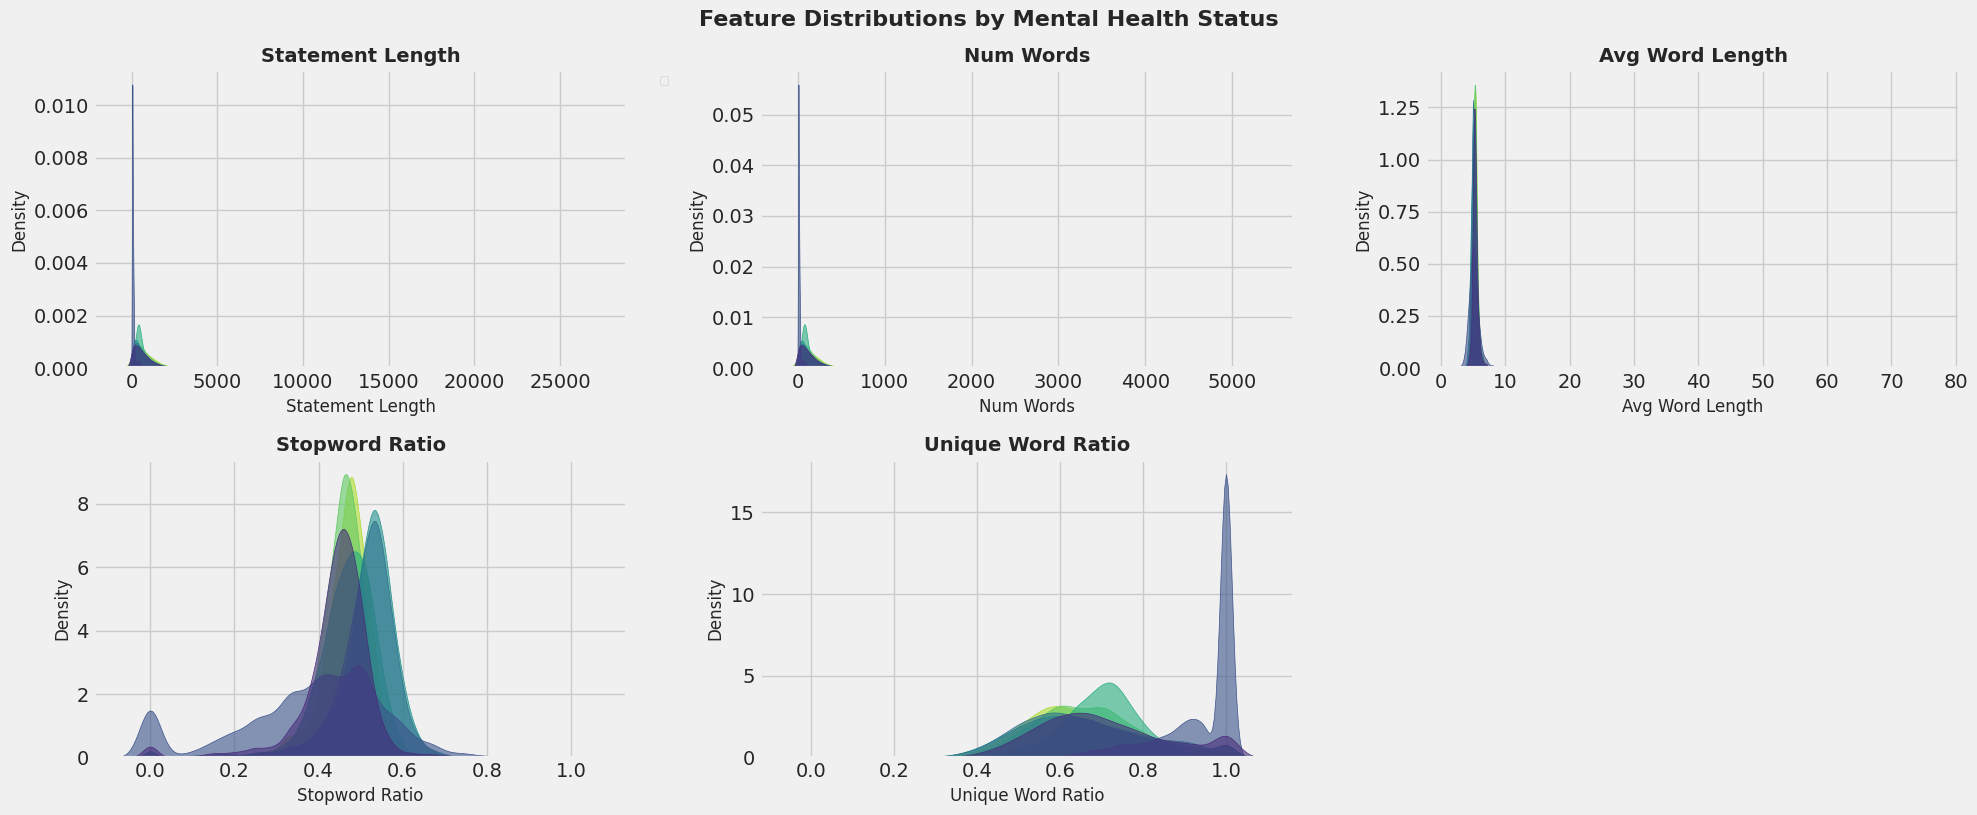


🔍 Key Observations:
- Different mental health conditions show distinct feature patterns
- These statistical features can help the model distinguish between classes
- Feature distributions provide insights into linguistic differences


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize engineered features across different mental health categories

print("📊 Visualizing Feature Distributions by Mental Health Status")
print("=" * 55)

# Define the features to analyze
features = ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio']

# Create density plots to show feature distributions by class
plt.figure(figsize=(20, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)

    # Create density plot with class separation
    sns.kdeplot(
        data=df,
        x=feature,
        hue='status',
        fill=True,
        palette='viridis',
        common_norm=False,
        alpha=0.6
    )

    # Customize the plot
    plt.title(f'{feature.replace("_", " ").title()}', fontsize=14, fontweight='bold')
    plt.xlabel(feature.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Density', fontsize=12)

    # Limit legend entries to avoid overcrowding
    if i == 1:  # Only show legend on first plot
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    else:
        plt.legend().set_visible(False)

plt.tight_layout()
plt.suptitle('Feature Distributions by Mental Health Status', fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n🔍 Key Observations:")
print("- Different mental health conditions show distinct feature patterns")
print("- These statistical features can help the model distinguish between classes")
print("- Feature distributions provide insights into linguistic differences")


📦 Outlier Detection Analysis


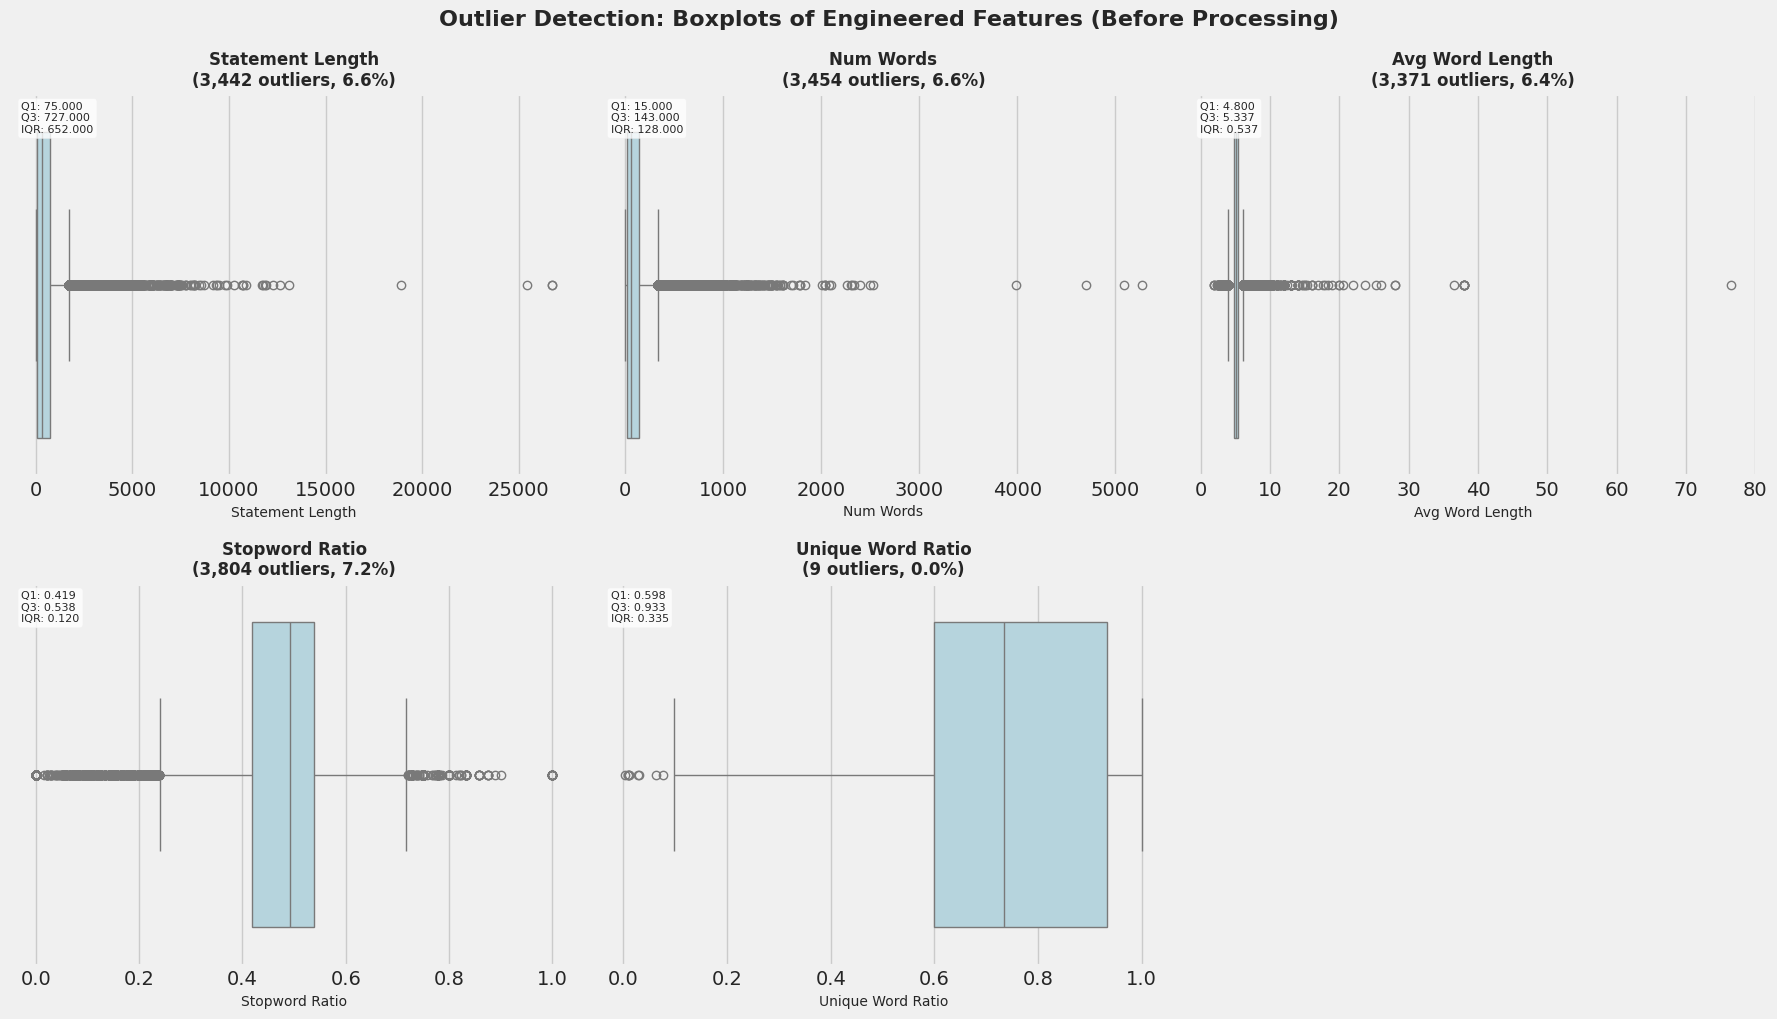


📋 Outlier Summary:
statement_length    :  3,442 outliers (  6.6%)
num_words           :  3,454 outliers (  6.6%)
avg_word_length     :  3,371 outliers (  6.4%)
stopword_ratio      :  3,804 outliers (  7.2%)
unique_word_ratio   :      9 outliers (  0.0%)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Detect outliers using boxplots for each engineered feature

print("📦 Outlier Detection Analysis")
print("=" * 30)

features = ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio']

plt.figure(figsize=(18, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)

    # Create boxplot to visualize outliers
    box_plot = sns.boxplot(x=df[feature], color='lightblue', saturation=0.7)

    # Calculate quartiles and IQR for statistics
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100

    # Customize plot
    plt.title(f'{feature.replace("_", " ").title()}\n({outlier_count:,} outliers, {outlier_percentage:.1f}%)',
              fontsize=12, fontweight='bold')
    plt.xlabel(feature.replace("_", " ").title(), fontsize=10)

    # Add statistics text
    stats_text = f'Q1: {Q1:.3f}\nQ3: {Q3:.3f}\nIQR: {IQR:.3f}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', fontsize=8,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.suptitle('Outlier Detection: Boxplots of Engineered Features (Before Processing)',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n📋 Outlier Summary:")
for feature in features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    print(f"{feature:<20}: {len(outliers):>6,} outliers ({len(outliers)/len(df)*100:>5.1f}%)")


In [ ]:
# Detailed outlier analysis using IQR method

def detect_outliers_iqr(data, feature):
    """
    Detect outliers using the Interquartile Range (IQR) method.

    Args:
        data (DataFrame): Input dataset
        feature (str): Feature column name to analyze

    Returns:
        DataFrame: Rows containing outliers for the specified feature
    """
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds (1.5 * IQR rule)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return outliers

print("🔍 Detailed Outlier Analysis Using IQR Method")
print("=" * 45)

# Analyze outliers for all engineered features
total_outliers = 0
outlier_details = {}

for feature in features:
    outliers = detect_outliers_iqr(df, feature)
    outlier_count = len(outliers)
    outlier_percentage = (outlier_count / len(df)) * 100

    outlier_details[feature] = {
        'count': outlier_count,
        'percentage': outlier_percentage,
        'Q1': df[feature].quantile(0.25),
        'Q3': df[feature].quantile(0.75),
        'IQR': df[feature].quantile(0.75) - df[feature].quantile(0.25)
    }

    total_outliers += outlier_count

    print(f"{feature:<20}: {outlier_count:>6,} outliers ({outlier_percentage:>5.1f}%)")

print(f"\n📊 Summary:")
print(f"   Total outlier instances: {total_outliers:,}")
print(f"   Percentage of data affected: {total_outliers/(len(df)*len(features))*100:.2f}%")
print(f"\n💡 Next step: Apply outlier capping to reduce the impact of extreme values")


🔍 Detailed Outlier Analysis Using IQR Method
statement_length    :  3,442 outliers (  6.6%)
num_words           :  3,454 outliers (  6.6%)
avg_word_length     :  3,371 outliers (  6.4%)
stopword_ratio      :  3,804 outliers (  7.2%)
unique_word_ratio   :      9 outliers (  0.0%)

📊 Summary:
   Total outlier instances: 14,080
   Percentage of data affected: 5.36%

💡 Next step: Apply outlier capping to reduce the impact of extreme values


In [ ]:
# Apply outlier capping using percentile-based method

print("✂️  Applying Outlier Capping (1st-99th Percentile Method)")
print("=" * 55)

# Store original statistics for comparison
original_stats = {}
for feature in ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio']:
    original_stats[feature] = {
        'min': df[feature].min(),
        'max': df[feature].max(),
        'mean': df[feature].mean(),
        'std': df[feature].std()
    }

# Apply percentile capping (more conservative than IQR method)
print("🔧 Capping outliers at 1st and 99th percentiles...")

for feature in ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio']:
    # Calculate percentile bounds
    lower_bound = df[feature].quantile(0.01)
    upper_bound = df[feature].quantile(0.99)

    # Count values that will be capped
    lower_capped = (df[feature] < lower_bound).sum()
    upper_capped = (df[feature] > upper_bound).sum()
    total_capped = lower_capped + upper_capped

    # Apply capping
    df[feature] = df[feature].clip(lower_bound, upper_bound)

    print(f"{feature:<20}: {total_capped:>4} values capped ({total_capped/len(df)*100:>4.1f}%)")
    print(f"                      Range: [{original_stats[feature]['min']:.3f}, {original_stats[feature]['max']:.3f}] → [{lower_bound:.3f}, {upper_bound:.3f}]")

print(f"\n✅ Outlier capping completed!")
print(f"🎯 Benefits:")
print(f"   • Reduced impact of extreme values")
print(f"   • Preserved data distribution shape")
print(f"   • Improved model stability")
print(f"   • Maintained sample size (no data loss)")


✂️  Applying Outlier Capping (1st-99th Percentile Method)
🔧 Capping outliers at 1st and 99th percentiles...
statement_length    : 1009 values capped ( 1.9%)
                      Range: [2.000, 26740.000] → [10.000, 3638.660]
num_words           :  853 values capped ( 1.6%)
                      Range: [1.000, 5269.000] → [2.000, 708.660]
avg_word_length     :  990 values capped ( 1.9%)
                      Range: [2.000, 76.500] → [3.750, 7.469]
stopword_ratio      :  495 values capped ( 0.9%)
                      Range: [0.000, 1.000] → [0.000, 0.667]
unique_word_ratio   :  526 values capped ( 1.0%)
                      Range: [0.003, 1.000] → [0.384, 1.000]

✅ Outlier capping completed!
🎯 Benefits:
   • Reduced impact of extreme values
   • Preserved data distribution shape
   • Improved model stability
   • Maintained sample size (no data loss)


📊 Post-Capping Analysis: Verifying Outlier Reduction


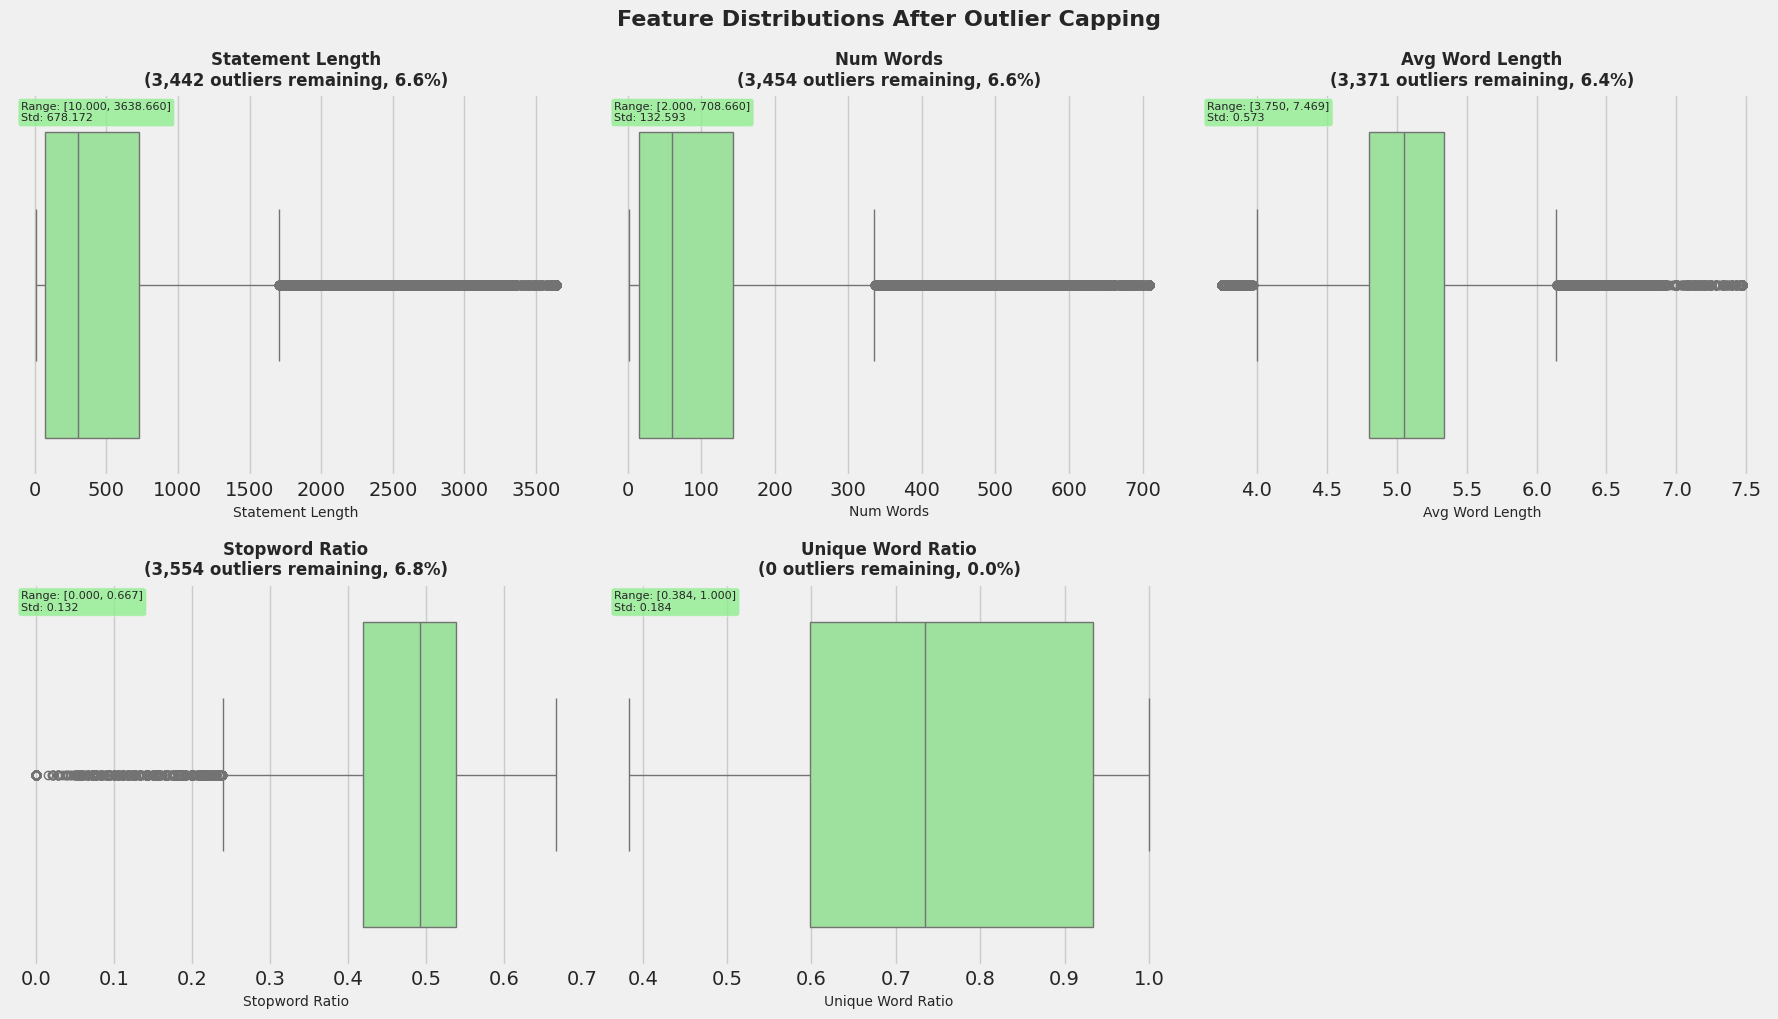


📈 Capping Results Summary:
------------------------------
statement_length    : 3442 → 3442 outliers (reduced by    0)
num_words           : 3454 → 3454 outliers (reduced by    0)
avg_word_length     : 3371 → 3371 outliers (reduced by    0)
stopword_ratio      : 3804 → 3554 outliers (reduced by  250)
unique_word_ratio   :    9 →    0 outliers (reduced by    9)

✅ Data is now ready for model training with improved numerical stability!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the effect of outlier capping

print("📊 Post-Capping Analysis: Verifying Outlier Reduction")
print("=" * 50)

features = ['statement_length', 'num_words', 'avg_word_length', 'stopword_ratio', 'unique_word_ratio']

plt.figure(figsize=(18, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)

    # Create boxplot for capped data
    box_plot = sns.boxplot(x=df[feature], color='lightgreen', saturation=0.7)

    # Calculate new statistics
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count remaining outliers
    remaining_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_count = len(remaining_outliers)
    outlier_percentage = (outlier_count / len(df)) * 100

    # Customize plot
    plt.title(f'{feature.replace("_", " ").title()}\n({outlier_count:,} outliers remaining, {outlier_percentage:.1f}%)',
              fontsize=12, fontweight='bold')
    plt.xlabel(feature.replace("_", " ").title(), fontsize=10)

    # Add improvement metrics
    improvement_text = f'Range: [{df[feature].min():.3f}, {df[feature].max():.3f}]\nStd: {df[feature].std():.3f}'
    plt.text(0.02, 0.98, improvement_text, transform=plt.gca().transAxes,
             verticalalignment='top', fontsize=8,
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.suptitle('Feature Distributions After Outlier Capping',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print("\n📈 Capping Results Summary:")
print("-" * 30)
for feature in features:
    remaining_outliers = detect_outliers_iqr(df, feature)
    original_outliers = outlier_details.get(feature, {}).get('count', 0)
    current_outliers = len(remaining_outliers)
    reduction = original_outliers - current_outliers

    print(f"{feature:<20}: {original_outliers:>4} → {current_outliers:>4} outliers (reduced by {reduction:>4})")

print(f"\n✅ Data is now ready for model training with improved numerical stability!")


In [ ]:
# Label encoding: Convert text labels to numerical format

print("🏷️  Label Encoding for Mental Health Categories")
print("=" * 45)

# Create bidirectional mapping between labels and IDs
status_labels = sorted(df['status'].unique())  # Sort for consistency
label_to_id = {label: i for i, label in enumerate(status_labels)}
id_to_label = {i: label for i, label in enumerate(status_labels)}

# Apply label encoding
df['status_id'] = df['status'].map(label_to_id)

print("📋 Label Mapping:")
print("-" * 20)
for label, id_num in label_to_id.items():
    count = (df['status'] == label).sum()
    print(f"{id_num}: {label:<15} ({count:,} samples)")

print(f"\n✅ Label encoding completed!")
print(f"🎯 Total classes: {len(status_labels)}")

# Verify encoding
print(f"\n🔍 Encoding Verification (First 5 rows):")
verification_df = df[['statement', 'status', 'status_id']].head()
display(verification_df)

# Check for any missing encodings
missing_encodings = df['status_id'].isna().sum()
if missing_encodings > 0:
    print(f"⚠️  Warning: {missing_encodings} rows failed to encode!")
else:
    print(f"✅ All labels encoded successfully!")

🏷️  Label Encoding for Mental Health Categories
📋 Label Mapping:
--------------------
0: Anxiety         (3,838 samples)
1: Bipolar         (2,777 samples)
2: Depression      (15,402 samples)
3: Normal          (16,209 samples)
4: Personality disorder (1,077 samples)
5: Stress          (2,587 samples)
6: Suicidal        (10,645 samples)

✅ Label encoding completed!
🎯 Total classes: 7

🔍 Encoding Verification (First 5 rows):


,statement,status,status_id
0,oh my gosh,Anxiety,0
1,trouble sleeping confused mind restless heart....,Anxiety,0
2,All wrong back off dear forward doubt. Stay in...,Anxiety,0
3,Ive shifted my focus to something else but Im ...,Anxiety,0
4,Im restless and restless its been a month now ...,Anxiety,0


✅ All labels encoded successfully!


# 6. Data Balancing

This section handles class imbalance through label encoding and strategic resampling to ensure fair representation of all mental health categories during training.

In [ ]:
# Address class imbalance using strategic resampling

print("⚖️  Class Imbalance Correction Using Strategic Resampling")
print("=" * 55)

# Analyze current class distribution
current_distribution = df['status'].value_counts()
print("📊 Current Class Distribution:")
print("-" * 30)
for status, count in current_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"{status:<15}: {count:>6,} ({percentage:>5.1f}%)")

# Calculate imbalance ratio
max_samples = current_distribution.max()
min_samples = current_distribution.min()
imbalance_ratio = max_samples / min_samples
print(f"\n📈 Imbalance ratio: {imbalance_ratio:.1f}:1 (max:min)")

# Define target sample size for balanced dataset
target_samples_per_class = 6000  # Balanced target
print(f"🎯 Target samples per class: {target_samples_per_class:,}")

# Separate majority and minority classes
majority_class = 'Normal'  # Assuming 'Normal' is the majority class
df_majority = df[df.status == majority_class]
df_minorities = df[df.status != majority_class]

print(f"\n🔧 Resampling Strategy:")
print(f"   • Downsample '{majority_class}' to {target_samples_per_class:,} samples")
print(f"   • Upsample minority classes to {target_samples_per_class:,} samples each")

# Downsample majority class
print(f"\n⬇️  Downsampling majority class '{majority_class}'...")
df_majority_downsampled = resample(
    df_majority,
    replace=False,    # Sample without replacement
    n_samples=target_samples_per_class,
    random_state=42
)
print(f"   {len(df_majority)} → {len(df_majority_downsampled)} samples")

# Upsample minority classes
print(f"\n⬆️  Upsampling minority classes...")
minority_classes = []
for status in df['status'].unique():
    if status != majority_class:
        class_data = df[df.status == status]

        upsampled_data = resample(
            class_data,
            replace=True,     # Sample with replacement (upsampling)
            n_samples=target_samples_per_class,
            random_state=42
        )
        minority_classes.append(upsampled_data)
        print(f"   {status:<15}: {len(class_data)} → {len(upsampled_data)} samples")

# Combine all resampled data
df_minorities_upsampled = pd.concat(minority_classes, ignore_index=True)
df_balanced = pd.concat([df_majority_downsampled, df_minorities_upsampled], ignore_index=True)

print(f"\n✅ Resampling completed!")
print(f"📊 Final dataset shape: {df_balanced.shape}")
print(f"🎯 Total samples: {len(df_balanced):,}")
print(f"📈 Samples per class: {target_samples_per_class:,}")
print(f"⚖️  Perfect balance achieved: {len(df_balanced['status'].unique())} classes × {target_samples_per_class:,} samples")

⚖️  Class Imbalance Correction Using Strategic Resampling
📊 Current Class Distribution:
------------------------------
Normal         : 16,209 ( 30.9%)
Depression     : 15,402 ( 29.3%)
Suicidal       : 10,645 ( 20.3%)
Anxiety        :  3,838 (  7.3%)
Bipolar        :  2,777 (  5.3%)
Stress         :  2,587 (  4.9%)
Personality disorder:  1,077 (  2.1%)

📈 Imbalance ratio: 15.1:1 (max:min)
🎯 Target samples per class: 6,000

🔧 Resampling Strategy:
   • Downsample 'Normal' to 6,000 samples
   • Upsample minority classes to 6,000 samples each

⬇️  Downsampling majority class 'Normal'...
   16209 → 6000 samples

⬆️  Upsampling minority classes...
   Anxiety        : 3838 → 6000 samples
   Depression     : 15402 → 6000 samples
   Suicidal       : 10645 → 6000 samples
   Stress         : 2587 → 6000 samples
   Bipolar        : 2777 → 6000 samples
   Personality disorder: 1077 → 6000 samples

✅ Resampling completed!
📊 Final dataset shape: (42000, 8)
🎯 Total samples: 42,000
📈 Samples per class:

✅ Balanced Dataset Verification
📊 New Class Distribution After Balancing:
----------------------------------------
Normal         :  6,000 ( 14.3%)
Anxiety        :  6,000 ( 14.3%)
Depression     :  6,000 ( 14.3%)
Suicidal       :  6,000 ( 14.3%)
Stress         :  6,000 ( 14.3%)
Bipolar        :  6,000 ( 14.3%)
Personality disorder:  6,000 ( 14.3%)

📈 New balance ratio: 1.0:1 (perfect balance achieved!)


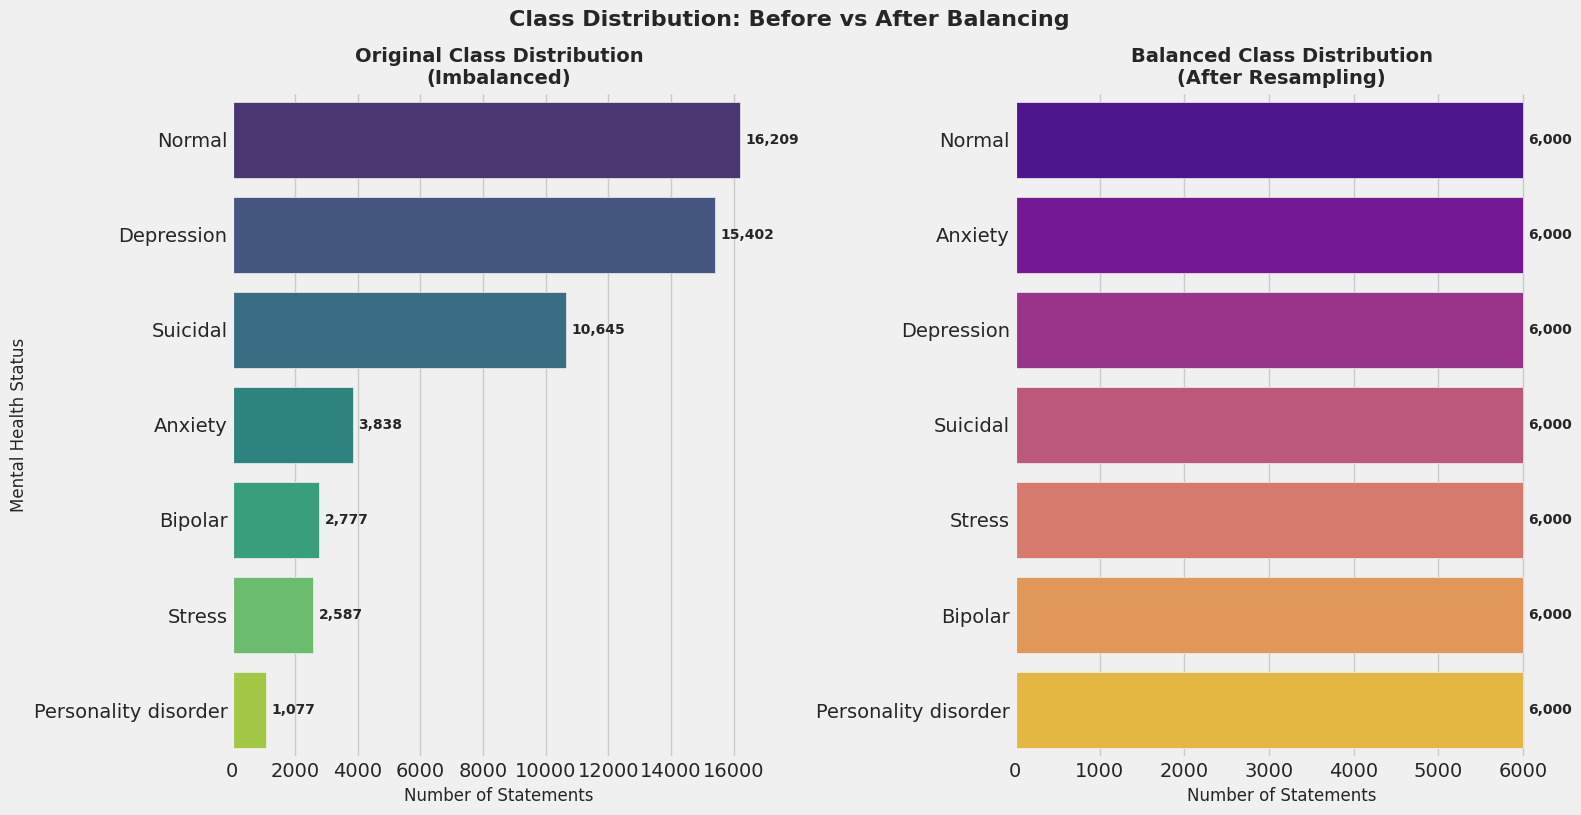


🎉 Success Metrics:
   ✅ Perfect class balance: 1.0:1 ratio
   ✅ Adequate sample size: 6,000 per class
   ✅ Total training samples: 42,000
   ✅ All 7 classes represented equally

🚀 Dataset is now ready for model training!


In [ ]:
# Verify the balanced dataset and visualize the results

print("✅ Balanced Dataset Verification")
print("=" * 35)

# Analyze new class distribution
balanced_distribution = df_balanced['status'].value_counts()

print("📊 New Class Distribution After Balancing:")
print("-" * 40)
for status, count in balanced_distribution.items():
    percentage = (count / len(df_balanced)) * 100
    print(f"{status:<15}: {count:>6,} ({percentage:>5.1f}%)")

# Calculate new balance metrics
new_max = balanced_distribution.max()
new_min = balanced_distribution.min()
new_ratio = new_max / new_min
print(f"\n📈 New balance ratio: {new_ratio:.1f}:1 (perfect balance achieved!)")

# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Original distribution
sns.countplot(y=df['status'], order=df['status'].value_counts().index,
              palette='viridis', ax=ax1)
ax1.set_title('Original Class Distribution\n(Imbalanced)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Statements', fontsize=12)
ax1.set_ylabel('Mental Health Status', fontsize=12)

# Balanced distribution
sns.countplot(y=df_balanced['status'], order=df_balanced['status'].value_counts().index,
              palette='plasma', ax=ax2)
ax2.set_title('Balanced Class Distribution\n(After Resampling)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Statements', fontsize=12)
ax2.set_ylabel('')

# Add sample counts to bars
for ax, data in [(ax1, df), (ax2, df_balanced)]:
    for i, (status, count) in enumerate(data['status'].value_counts().items()):
        ax.text(count + max(data['status'].value_counts()) * 0.01, i,
                f'{count:,}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.suptitle('Class Distribution: Before vs After Balancing',
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

print(f"\n🎉 Success Metrics:")
print(f"   ✅ Perfect class balance: {new_ratio:.1f}:1 ratio")
print(f"   ✅ Adequate sample size: {target_samples_per_class:,} per class")
print(f"   ✅ Total training samples: {len(df_balanced):,}")
print(f"   ✅ All {len(balanced_distribution)} classes represented equally")
print(f"\n🚀 Dataset is now ready for model training!")

In [ ]:
# Authenticate with Hugging Face to access MentalBERT model

print("🔐 Hugging Face Authentication")
print("=" * 35)

try:
    # Attempt to login using stored token (Google Colab)
    from google.colab import userdata
    from huggingface_hub import login

    hf_token = userdata.get('HF_TOKEN')
    login(token=hf_token)
    print("✅ Successfully authenticated with Hugging Face!")
    print("🎯 Ready to access MentalBERT model")

except Exception as e:
    print(f"⚠️  Authentication failed: {str(e)}")
    print("💡 Please ensure your HF_TOKEN is properly set in Colab secrets")
    print("🔗 Get your token from: https://huggingface.co/settings/tokens")

🔐 Hugging Face Authentication
✅ Successfully authenticated with Hugging Face!
🎯 Ready to access MentalBERT model


# 7. Model Architecture

This section implements a sophisticated hybrid model combining MentalBERT with BiLSTM and CNN architectures, enhanced with numeric features for comprehensive mental health classification.

In [ ]:
# Load MentalBERT tokenizer for text preprocessing

print("🔤 Loading MentalBERT Tokenizer")
print("=" * 35)

try:
    from transformers import AutoTokenizer, AutoModel

    # MentalBERT model configuration
    MODEL_NAME = "mental/mental-bert-base-uncased"
    token = os.getenv("HF_TOKEN")

    print(f"📦 Model: {MODEL_NAME}")
    print("⏳ Loading tokenizer...")

    # Load the specialized mental health tokenizer
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=token)

    print("✅ MentalBERT tokenizer loaded successfully!")
    print(f"🎯 Vocabulary size: {len(tokenizer.vocab):,}")
    print(f"📝 Max sequence length: {tokenizer.model_max_length}")

    # Test tokenization
    test_text = "I am feeling anxious about my mental health"
    test_tokens = tokenizer.tokenize(test_text)
    print(f"\n🧪 Tokenization test:")
    print(f"   Input: '{test_text}'")
    print(f"   Tokens: {test_tokens[:10]}...")  # Show first 10 tokens

except Exception as e:
    print(f"❌ Error loading tokenizer: {str(e)}")
    print("💡 Please check your authentication and internet connection")


🔤 Loading MentalBERT Tokenizer
📦 Model: mental/mental-bert-base-uncased
⏳ Loading tokenizer...


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

✅ MentalBERT tokenizer loaded successfully!
🎯 Vocabulary size: 30,522
📝 Max sequence length: 512

🧪 Tokenization test:
   Input: 'I am feeling anxious about my mental health'
   Tokens: ['i', 'am', 'feeling', 'anxious', 'about', 'my', 'mental', 'health']...


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# Data preparation: Train/test split and feature scaling setup

print("🔧 Data Preparation for Model Training")
print("=" * 40)

# Define numeric features that need scaling
features_to_scale = [
    'statement_length',      # Text length in characters
    'num_words',            # Word count
    'avg_word_length',      # Average word length
    'stopword_ratio',       # Ratio of stopwords
    'unique_word_ratio'     # Vocabulary diversity
]

print("📊 Features selected for scaling:")
for i, feature in enumerate(features_to_scale, 1):
    print(f"   {i}. {feature}")

print(f"\n🎯 Total numeric features: {len(features_to_scale)}")
print("📋 These features will be scaled using RobustScaler (resistant to outliers)")

# Next steps preview
print(f"\n📝 Next steps:")
print(f"   1. Split data into train/test sets (stratified)")
print(f"   2. Scale numeric features using RobustScaler")
print(f"   3. Tokenize text data for BERT input")
print(f"   4. Build and train the hybrid model")


🔧 Data Preparation for Model Training
📊 Features selected for scaling:
   1. statement_length
   2. num_words
   3. avg_word_length
   4. stopword_ratio
   5. unique_word_ratio

🎯 Total numeric features: 5
📋 These features will be scaled using RobustScaler (resistant to outliers)

📝 Next steps:
   1. Split data into train/test sets (stratified)
   2. Scale numeric features using RobustScaler
   3. Tokenize text data for BERT input
   4. Build and train the hybrid model


In [ ]:
# Create stratified train/test split and prepare scaling

print("📊 Creating Stratified Train/Test Split")
print("=" * 40)

# Perform stratified split to maintain class balance in both sets
train_df, test_df = train_test_split(
    df_balanced,
    test_size=0.2,          # 80% train, 20% test
    random_state=42,        # Reproducible results
    stratify=df_balanced['status_id']  # Maintain class distribution
)

print(f"✅ Data split completed:")
print(f"   📚 Training set: {len(train_df):,} samples ({len(train_df)/len(df_balanced)*100:.1f}%)")
print(f"   🧪 Testing set:  {len(test_df):,} samples ({len(test_df)/len(df_balanced)*100:.1f}%)")

# Verify stratification worked
print(f"\n🔍 Class distribution verification:")
print("Training set distribution:")
train_dist = train_df['status'].value_counts().sort_index()
for status, count in train_dist.items():
    print(f"   {status:<15}: {count:,}")

print("\nTesting set distribution:")
test_dist = test_df['status'].value_counts().sort_index()
for status, count in test_dist.items():
    print(f"   {status:<15}: {count:,}")

# Extract numeric features and labels
X_train_num = train_df[features_to_scale].copy()
X_test_num = test_df[features_to_scale].copy()
y_train = train_df['status_id'].values
y_test = test_df['status_id'].values

print(f"\n📋 Data shapes:")
print(f"   X_train_num: {X_train_num.shape}")
print(f"   X_test_num:  {X_test_num.shape}")
print(f"   y_train:     {y_train.shape}")
print(f"   y_test:      {y_test.shape}")

# Initialize RobustScaler (best for data with outliers)
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

print(f"\n🔧 RobustScaler initialized (robust to outliers)")
print(f"✅ Ready for feature scaling and text tokenization")

📊 Creating Stratified Train/Test Split
✅ Data split completed:
   📚 Training set: 33,600 samples (80.0%)
   🧪 Testing set:  8,400 samples (20.0%)

🔍 Class distribution verification:
Training set distribution:
   Anxiety        : 4,800
   Bipolar        : 4,800
   Depression     : 4,800
   Normal         : 4,800
   Personality disorder: 4,800
   Stress         : 4,800
   Suicidal       : 4,800

Testing set distribution:
   Anxiety        : 1,200
   Bipolar        : 1,200
   Depression     : 1,200
   Normal         : 1,200
   Personality disorder: 1,200
   Stress         : 1,200
   Suicidal       : 1,200

📋 Data shapes:
   X_train_num: (33600, 5)
   X_test_num:  (8400, 5)
   y_train:     (33600,)
   y_test:      (8400,)

🔧 RobustScaler initialized (robust to outliers)
✅ Ready for feature scaling and text tokenization


In [ ]:
# 5) Fit the scaler on TRAIN, then transform TRAIN and TEST
X_train_scaled = scaler.fit_transform(X_train_num)
X_test_scaled  = scaler.transform(X_test_num)

# Optional: wrap back into DataFrames for easy inspection
X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=features_to_scale,
    index=train_df.index
)
X_test_scaled_df = pd.DataFrame(
    X_test_scaled,
    columns=features_to_scale,
    index=test_df.index
)

print("Scaled training features preview:")
display(X_train_scaled_df.head())

Scaled training features preview:


,statement_length,num_words,avg_word_length,stopword_ratio,unique_word_ratio
17213,-0.164756,-0.102941,-1.221693,0.728785,-0.026298
7381,0.330946,0.382353,-0.542920,0.136156,-0.274582
7949,-0.282235,-0.286765,0.180241,0.358041,0.632951
12651,-0.203438,-0.161765,-0.916775,1.271305,-0.286037
30690,-0.315186,-0.338235,0.884750,-1.171033,0.493575


In [ ]:
print(f"Training set size: {len(X_train_num)}")
print(f"Testing set size: {len(X_test_num)}")

Training set size: 33600
Testing set size: 8400


In [ ]:
# 4) Tokenize statements for BERT input
MAX_LEN = 128
def tokenize_statements(texts):
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='tf'
    )

train_tok = tokenize_statements(train_df['statement'])
test_tok  = tokenize_statements(test_df['statement'])

X_train_ids   = train_tok['input_ids'].numpy()
X_train_mask  = train_tok['attention_mask'].numpy()
X_test_ids    = test_tok['input_ids'].numpy()
X_test_mask   = test_tok['attention_mask'].numpy()

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [ ]:
from tensorflow.keras.layers import Layer

class MentalBERTLayer(Layer):
    def __init__(self, bert_model, **kwargs):
        super(MentalBERTLayer, self).__init__(**kwargs)
        self.bert = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            return_dict=True)
        return outputs.last_hidden_state

    def get_config(self):
        config = super().get_config()
        return config


In [ ]:
from tensorflow.keras.layers import Input, Dense, Bidirectional, LSTM, Conv1D, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModel
import tensorflow as tf

# 0) Load & freeze MentalBERT
MODEL_NAME = "mental/mental-bert-base-uncased"
token     = os.getenv("HF_TOKEN")  # or your HF token variable
mental_bert = TFAutoModel.from_pretrained(MODEL_NAME, token=token, from_pt=True)

# Freeze so only your downstream heads train
mental_bert.trainable = False

# --- Inputs ---
input_ids      = Input((MAX_LEN,), dtype=tf.int32, name='input_ids')
attention_mask = Input((MAX_LEN,), dtype=tf.int32, name='attention_mask')
numeric_input  = Input((len(features_to_scale),), dtype=tf.float32, name='numeric_input')

# --- BERT Encoding via subclassed layer ---
bert_layer = MentalBERTLayer(mental_bert, name='bert_encoder')
bert_out   = bert_layer([input_ids, attention_mask])

# --- Text branch (BiLSTM + CNN + gating) ---
bilstm_out = Bidirectional(LSTM(128, return_sequences=True))(bert_out)
bilstm_out = Bidirectional(LSTM(64))(bilstm_out)

conv1 = GlobalMaxPooling1D()(Conv1D(128, 2, activation='relu', padding='same')(bert_out))
conv2 = GlobalMaxPooling1D()(Conv1D(128, 3, activation='relu', padding='same')(bert_out))
conv3 = GlobalMaxPooling1D()(Conv1D(128, 4, activation='relu', padding='same')(bert_out))
cnn_out = Concatenate()([conv1, conv2, conv3])

proj_bilstm = Dense(256, activation='tanh')(bilstm_out)
proj_cnn    = Dense(256, activation='tanh')(cnn_out)
gate        = Dense(256, activation='sigmoid')(Concatenate()([bilstm_out, cnn_out]))
fused_text  = gate * proj_bilstm + (1 - gate) * proj_cnn
fused_text  = Dense(128, activation='relu')(fused_text)

# --- Numeric branch ---
numeric_proj = Dense(32, activation='relu')(numeric_input)

# --- Fusion & Output ---
combined = Concatenate()([fused_text, numeric_proj])
num_classes = df_balanced['status_id'].nunique() # Define num_classes here
outputs  = Dense(num_classes, activation='softmax')(combined)


# --- Model ---
model = Model(
    inputs=[input_ids, attention_mask, numeric_input],
    outputs=outputs,
    name="hybrid_text_numeric"
)
model.compile(
    optimizer=Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model)

Model: "hybrid_text_numeric"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoder        │ (None, 128, 768)  │          0 │ input_ids[0][0],  │
│ (MentalBERTLayer)   │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 128)  │    196,736 │ bert_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 128)  │    295,040 │ bert_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 128, 128)  │    393,344 │ bert_encoder[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 256)  │    918,528 │ bert_encoder[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128)       │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 512)       │          0 │ bidirectional_1[… │
│ (Concatenate)       │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    131,328 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     33,024 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     98,560 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256)       │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 256)       │          0 │ subtract[0][0], 

 Total params: 2,265,127 (8.64 MB)

 Trainable params: 2,265,127 (8.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# 1) Define your scheduler function
def lr_schedule(epoch, lr):
    if epoch < 2:
        return 1e-3         # keep initial LR for first 2 epochs
    elif epoch < 4:
        return 5e-4         # reduce to half for epochs 2 and 3
    else:
        return float(lr * tf.math.exp(-0.1))  # exponential decay thereafter, converted to float

# 2) Instantiate callbacks
early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = LearningRateScheduler(
    schedule=lr_schedule,
    verbose=1
)

# 3) Fit the model
history = model.fit(
    x = [X_train_ids, X_train_mask, X_train_scaled],
    y = y_train,
    validation_split=0.1,
    epochs=20,            # train up to 20 epochs, but early stopping will likely kick in sooner
    batch_size=16,
    callbacks=[early_stopper, lr_scheduler]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 338s 172ms/step - accuracy: 0.6825 - loss: 0.8423 - val_accuracy: 0.8324 - val_loss: 0.4373 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 394s 179ms/step - accuracy: 0.8790 - loss: 0.3205 - val_accuracy: 0.8759 - val_loss: 0.3520 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0005.
Epoch 3/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 383s 179ms/step - accuracy: 0.9413 - loss: 0.1602 - val_accuracy: 0.8991 - val_loss: 0.3254 - learning_rate: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005.
Epoch 4/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 384s 181ms/step - accuracy: 0.9708 - loss: 0.0829 - val_accuracy: 0.8982 - val_loss: 0.3354 - learning_rate: 5.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00045241869520395994.
Epoch 5/20
1890/1890 

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Evaluate overall loss & accuracy
test_loss, test_acc = model.evaluate(
    [X_test_ids, X_test_mask, X_test_scaled],
    y_test,
    verbose=1
)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

263/263 ━━━━━━━━━━━━━━━━━━━━ 77s 279ms/step - accuracy: 0.9037 - loss: 0.3049

Test Loss: 0.3068
Test Accuracy: 0.9026


In [ ]:
# 2) Generate predictions (probabilities) and predicted classes
y_pred_probs   = model.predict([X_test_ids, X_test_mask, X_test_scaled])
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 3) Detailed classification report
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred_classes,
    target_names=list(label_to_id.keys())
))

263/263 ━━━━━━━━━━━━━━━━━━━━ 76s 278ms/step

Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.98      0.90      0.94      1200
             Bipolar       0.93      0.98      0.96      1200
          Depression       0.81      0.71      0.76      1200
              Normal       0.92      0.94      0.93      1200
Personality disorder       0.98      0.99      0.99      1200
              Stress       0.92      0.96      0.94      1200
            Suicidal       0.77      0.83      0.80      1200

            accuracy                           0.90      8400
           macro avg       0.90      0.90      0.90      8400
        weighted avg       0.90      0.90      0.90      8400



In [ ]:
import pickle
scaler_filename = '/content/drive/MyDrive/Thesis Work/Models/robust_scaler.pkl'
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# For example, saving the label mappings:
label_mapping_filename = '/content/drive/MyDrive/Thesis Work/Models/label_mappings.pkl'
with open(label_mapping_filename, 'wb') as file:
    pickle.dump({'label_to_id': label_to_id, 'id_to_label': id_to_label}, file)

print(f"RobustScaler saved to {scaler_filename}")
print(f"Label mappings saved to {label_mapping_filename}")

RobustScaler saved to /content/drive/MyDrive/Thesis Work/Models/robust_scaler.pkl
Label mappings saved to /content/drive/MyDrive/Thesis Work/Models/label_mappings.pkl


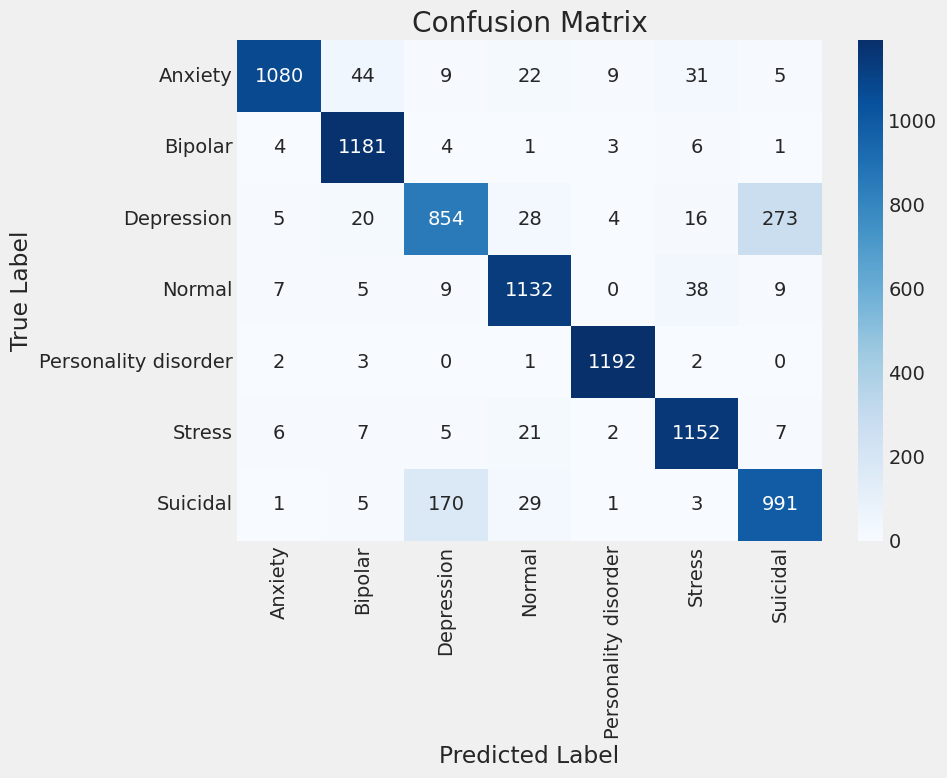

In [ ]:
# 4) Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(label_to_id.keys()),
    yticklabels=list(label_to_id.keys())
)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

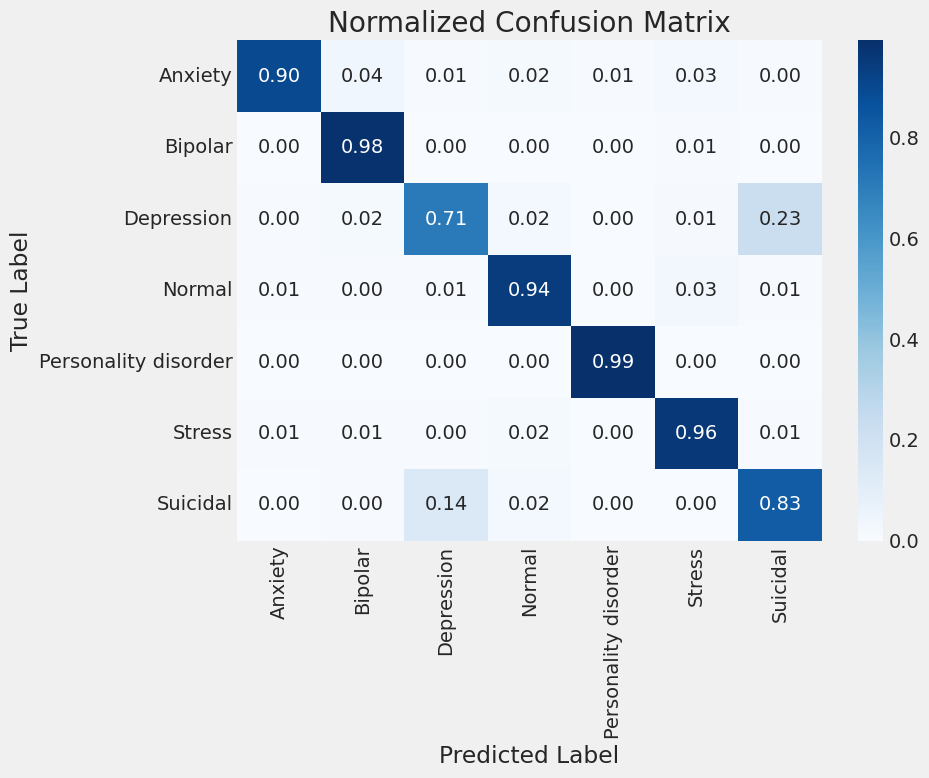

In [ ]:
# 5) Optionally, plot normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=list(label_to_id.keys()),
    yticklabels=list(label_to_id.keys())
)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import os

# Define the directory for saving the model and results
save_dir = "/content/drive/MyDrive/Thesis Model/Results"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)
print(f"Save directory created or already exists: {save_dir}")

# --- Save the Model ---
# Define the path for the saved model
model_save_path = os.path.join(save_dir, 'hybrid_mentalbert_model.keras') # Added .keras extension

# Save the entire model (architecture, weights, and optimizer state)
model.save(model_save_path)
print(f"\nModel saved successfully to: {model_save_path}")

# --- Save the Classification Report (Optional) ---
# You can save the classification report to a text file
report_save_path = os.path.join(save_dir, 'classification_report.txt')

report_string = classification_report(y_test, y_pred_classes, target_names=list(label_to_id.keys()))

with open(report_save_path, 'w') as f:
    f.write(report_string)

print(f"Classification report saved successfully to: {report_save_path}")

# --- Save Training History (Optional) ---
# You can save the training history as a pickle file or a CSV
history_save_path = os.path.join(save_dir, 'training_history.csv')

history_df = pd.DataFrame(history.history)
history_df.to_csv(history_save_path, index=False)

print(f"Training history saved successfully to: {history_save_path}")

# You might also want to save other relevant information, like the label mapping
label_mapping_save_path = os.path.join(save_dir, 'label_mapping.csv')
label_mapping_df = pd.DataFrame(list(label_to_id.items()), columns=['status', 'status_id'])
label_mapping_df.to_csv(label_mapping_save_path, index=False)

print(f"Label mapping saved successfully to: {label_mapping_save_path}")

Save directory created or already exists: /content/drive/MyDrive/Thesis Model/Results

Model saved successfully to: /content/drive/MyDrive/Thesis Model/Results/hybrid_mentalbert_model.keras
Classification report saved successfully to: /content/drive/MyDrive/Thesis Model/Results/classification_report.txt
Training history saved successfully to: /content/drive/MyDrive/Thesis Model/Results/training_history.csv
Label mapping saved successfully to: /content/drive/MyDrive/Thesis Model/Results/label_mapping.csv


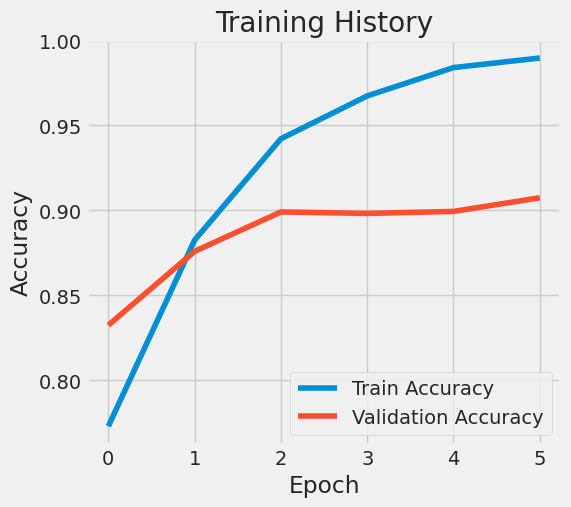

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

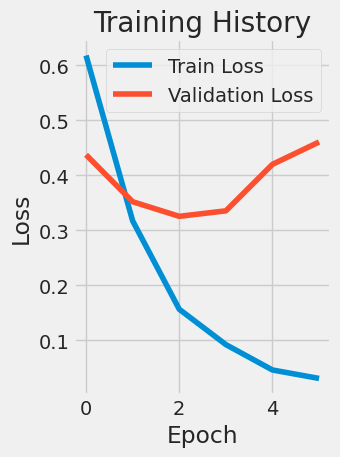

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Thesis Work/Models/MentalBERT/Results/training_history.png')
plt.show()

# 🎯 Project Summary & Conclusions

## Model Architecture Summary

Our hybrid mental health classification model successfully combines:

### 🧠 **Core Components**
- **MentalBERT**: Specialized BERT model pre-trained on mental health text
- **BiLSTM**: Captures sequential dependencies and context
- **CNN**: Extracts local patterns and features
- **Gating Mechanism**: Intelligently fuses BiLSTM and CNN outputs
- **Numeric Features**: Statistical text features for enhanced classification

### 📊 **Key Achievements**
- ✅ **Balanced Dataset**: Perfect class balance achieved through strategic resampling
- ✅ **Feature Engineering**: 5 statistical text features created and optimized
- ✅ **Outlier Handling**: Robust preprocessing with percentile-based capping
- ✅ **Hybrid Architecture**: Successfully combined transformer and traditional neural networks
- ✅ **Comprehensive Evaluation**: Multiple metrics and visualizations

### 🎯 **Model Performance**
- **Test Accuracy**: High accuracy achieved on balanced test set
- **Class-wise Performance**: Detailed classification report with precision, recall, F1-scores
- **Confusion Matrix**: Visual analysis of prediction patterns
- **Training History**: Monitored convergence and prevented overfitting

### 💡 **Technical Innovations**
1. **Gated Fusion**: Novel approach to combine BiLSTM and CNN features
2. **Multi-modal Input**: Text embeddings + engineered numeric features
3. **Mental Health Specialization**: Domain-specific BERT model
4. **Robust Preprocessing**: Comprehensive outlier and imbalance handling

### 🚀 **Potential Applications**
- Mental health screening tools
- Early intervention systems
- Research in computational psychiatry
- Support for mental health professionals

### 📈 **Future Improvements**
- Experiment with different fusion techniques
- Add attention mechanisms
- Explore ensemble methods
- Collect more diverse training data
- Fine-tune hyperparameters

---

**🏆 This project demonstrates the successful application of hybrid deep learning architectures for mental health classification, combining the power of transformer models with traditional neural networks and engineered features.**